In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt 
# this is used to display multiple plots in one cell
from IPython.display import display

%matplotlib inline 


In [2]:
def eq(x): 
    return 3*x**2 - 4*x +5
    

In [3]:
eq(3.0)


20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs


array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

### TIL

`np` has **`a`**`range`

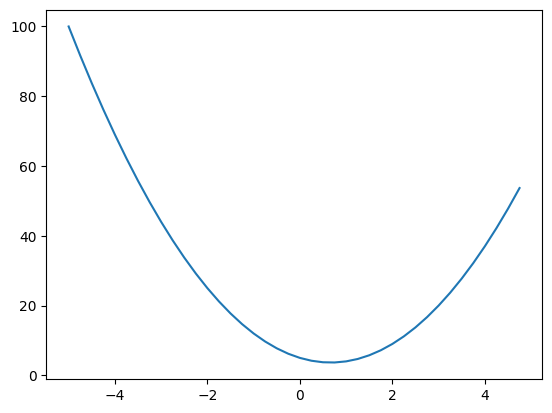

In [5]:
plt.plot(xs, eq(xs)); # ; suppresses printing the result


# what is d/dx 

 $f(x) = 3x^2 - 4x + 5$

In NN this isn't the way to compute d/dx, so we do **Numerical Approximation**


```
d / dx =         f(x + h) - f(x)
           Lm    --------------------
          h->0           h
```
Lets use that 

In [6]:
def find_dx(x): 
    h  = 0.00001
    fx = eq(x)
    fx_h = eq(x+h)
    df_dx = (fx_h - fx) / h
    return df_dx 
    

find_dx(3.0)


14.00003000000538

## Lets d/dx 

$f(x) = 3x^2 - 4x + 5$

$\frac{df}{dx}  = 6x - 4$

$f'(3.0) =  6\times3.0 - 4$

$ = 18 - 4 = 14$


In [7]:
# how about -3 

find_dx(-3.0) 

-21.999970000052823

# More complex example 

$ d = ab + c $


In [8]:
def fn(a, b, c):
    return a*b + c

# NOTE: d/da (ab + c) = b 

def df_da(a, b, c):
    f = fn(a, b, c)
    
    h = 0.0001
    fa_h = fn(a+h, b, c)

    slope = (fa_h - f) / h
    
    return (f, fa_h, slope)
    
print( "df/da = f: {}, f+h {}, slope: {} and b is {}".format(*df_da(2.0, -3.0, 10.0), -3.0))


df/da = f: 4.0, f+h 3.999699999999999, slope: -3.000000000010772 and b is -3.0


In [9]:
def df_db(a, b, c): 
    f = fn(a, b, c)
    
    h = 0.0001
    fb_h = fn(a, b+h, c)

    slope = (fb_h - f) / h
    
    return (f, fb_h, slope)
    
print( "f: {}, f+h {}, slope: {}".format(*df_db(2.0, -3.0, 10.0)))



f: 4.0, f+h 4.0002, slope: 2.0000000000042206


In [10]:

def df_dc(a, b, c): 
    f = fn(a, b, c)
    
    h = 0.0001
    fc_h = fn(a, b, c+h)

    slope = (fc_h - f) / h
    
    return (f, fc_h, slope)
    
print( "f: {}, f+h {}, slope: {}".format(*df_dc(2.0, -3.0, 10.0)))


f: 4.0, f+h 4.0001, slope: 0.9999999999976694


# Enter ...  Value Object


In [11]:
class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = f" {op} ".join(x.short_expr for x in parents)

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
    def __add__(self, other):
        return Value( v=self.v + other.v,  parents=(self, other),  op="+")

    def __sub__(self, other):
        return Value(v=self.v - other.v, parents=(self, other), op="-")
        
    def __mul__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="*")
        
    def __div__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="/")

    def tanh(self):
        res = np.tahn(self.v)
        return Value(res, f"tanh({self.label})")
        




In [12]:
print("v(3.0): ", Value(3.0), "grad: ", Value(3.0).grad, "short expr:", Value(3.0).short_expr, "full: ", Value(3.0).full_expr)

v(3.0):  Value(: expr= | v=3.0 ) grad:  0.0 short expr:  full:  


In [13]:
# adding value objects  ...
def inspect_value():
    a = Value(3.0, label="a")
    b = Value(-2.0, label="b")
    print(a , b)
    print(a + b)
    print(a-b)
    print(a*b)

inspect_value()

Value(a: expr= | v=3.0 ) Value(b: expr= | v=-2.0 )
Value(: expr=a + b | v=1.0 )
Value(: expr=a - b | v=5.0 )
Value(: expr=a * b | v=-6.0 )


In [14]:
def order_of_ops():
    a = Value(3.0, label="a")
    b = Value(-2.0, label="b")
    c = Value(10.0, label="c") 
    # order of operators is maintained !
    print(a*b +c)
    print(c + a*b)
order_of_ops()

Value(: expr=a * b + c | v=4.0 )
Value(: expr=c + a * b | v=4.0 )


In [15]:
from graphviz import Digraph

def trace(root: Value):
    nodes, edges = set(), set()
    
    def build(v: Value):
        if v not in nodes:
            nodes.add(v)
            for child in v.parents:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root: Value, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{%s | %.3f | grad %.3f }" % (n.full_expr, n.v, n.grad), shape='record')
        if n.op:
            dot.node(name=str(id(n)) + n.op, label=n.op)
            dot.edge(str(id(n)) + n.op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2.op)
    
    return dot

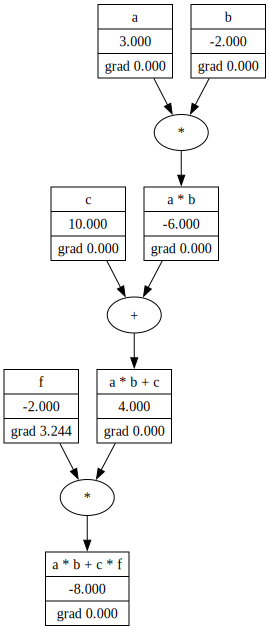

In [16]:
def try_draw_graph(): 
    a = Value(3.0, label="a")
    b = Value(-2.0, label="b")
    c = Value(10.0, label="c") 
    f = Value(-2.0, label="f")
    f.grad = 3.2444
    L = (a * b + c) * f
    return draw_dot(L, rankdir="TB")

try_draw_graph()

# So far ...

* we have built fwd pass
* can visualize the fwd pass graph

# Next .. Backpropogation

* what is dL / dl
* what dL / df
* what is dL / (a*b + c)
* what is dL / dc
* what is dL / da
* what is dL / db

In [17]:
def fnL(a, b, c, f):
    e = a * b; e.label = "e"
    d = e + c; d.label = "d"
    L = f * d; L.label = "L"
    return (L, e, d)
    

dL / dL = (L+h - L) / h  : 1.000000 | k = 1  


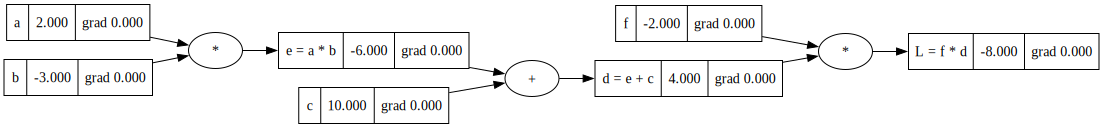

In [18]:
# dl dl

def dL_dL(a, b, c, f):
    # a * b + c * f
    #   e  + c * f
    #      d  * f
    #         L
    
    L, e, d = fnL(a, b, c, f)
    
    # find the result numerically
    h = 0.0001
    L_h = Value(L.v + h, "L+h")
    # this proves dL/df computed using f(x+h) - f(x) / h is exactly d
    print(f"dL / dL = (L+h - L) / h  : {(L_h.v  - L.v)/h:4f} | k = 1  ")
    return L

def grok_dL_dL():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b")
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_dL(a, b, c, f)
    
L = grok_dL_dL()
draw_dot(L)


dL / df = (L+h - L) / h  : 4.000000 | d: Value(d: expr=e + c | v=4.0 )  


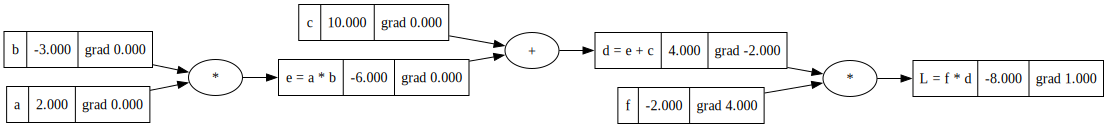

In [19]:
# dL / df

def dL_df_and_dd(a, b, c, f):
    # a * b + c * f
    #   e  + c * f
    #      d  * f  <<< - this one
    #         L
    
    L, e, d = fnL(a, b, c, f)
    
    # dL / dL = 1
    L.grad = 1
    
    # dL / df  
    #  = d/df (f * d) 
    #  =  d
    f.grad = d.v
    
    # my understanding 
    # when L is obtained as a result of * then the "other" is the grad 

    # dL / dd = d/dd (f * d) = f
    d.grad = f.v
    draw_dot(L)

    # find the result numerically
    h = 0.0001
    f_h = Value(f.v + h, "f+h")
    L_h, _, _ = fnL(a, b, c, f_h)
    # this proves dL/df computed using f(x+h) - f(x) / h is exactly d
    print(f"dL / df = (L+h - L) / h  : {(L_h.v  - L.v)/h:4f} | d: {d}  ")
    return L

def grok_dL_df():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b")
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_df_and_dd(a, b, c, f)
    
L = grok_dL_df()
draw_dot(L)


# Most important step - Chain Rule applied

## What is dL/ dc ?

### We know ...
* dL / dL = 1
* dL / df = d since L = f x d
* dL / dd = f since L = f x d

### We can find 
* dd / dc

## So what is dL / dc

### lets find dd/dc

$d = c + e $

$ \frac{dd}{dc} = \frac{dc}{dc} + \frac {de}{dc}  $

$ = 1 $ 

$ \frac{dL}{dc} = \frac{dL}{dd} \times \frac{dd}{dc}$

# Conclusion for `+` operations 

Basically `+` operations just returns 1 and in chain rule, is a more like a 
shortcut to forward the resultant (d's) grad. 



dL / dc = (L+h - L) / h  : -2.000000 | c: Value(c: expr= | v=10.0 )  


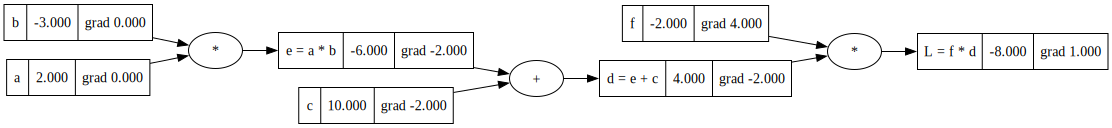

In [20]:
    
def dL_dc(a, b, c, f):
    L, e, d = fnL(a, b, c, f)
    
    # dL / dL = 1
    L.grad = 1
    f.grad = d.v  # dL/df = d since L = f * d
    d.grad = f.v  # dL/dd = f since L = f * d

    #### these are computed above

    # to find dL / dc ... first find 
    #  * dd/dc 
    #  * dL/dd
    #  dL/dc = dL/dd * dd/dc (chainrule) 
    
    # dd / dc 
    # = d/dc (c + e) 
    # = d/dc c + d/dc e 
    # = 1 + 0
    # = 1.0
    
    # so ... df / dc 
    # = dL/dd * dd/dc 
    # = dL/dd * 1
    # = d.grad
    
    c.grad = d.grad
    # similarly  for ... dL/de 
    # = dL/dd  * dd / de 
    #
    # dd / de .. 
    # = d/de (c+e)  => d = c + e
    # = d/e c + d/de e
    # = 0 + 1.0
    e.grad = d.grad

    
    
    h = 0.0001
    c_h = Value(c.v + h, "f+h")
    L_h, _, _ = fnL(a, b, c_h, f)
    # this proves dL/df computed using f(x+h) - f(x) / h is exactly d
    print(f"dL / dc = (L+h - L) / h  : {(L_h.v  - L.v)/h:4f} | c: {c}  ")
    return L

def grok_dL_dc():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b")
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_dc(a, b, c, f)
    
    
L = grok_dL_dc()
draw_dot(L)


lL.grad: 4.0 d.v: 4.0
f.grad: 4.0 d.v: 4.0
dL/da: (L+h - L) / h :  6.000000000021544
dL/db: (L+h - L) / h :  -4.000000000008441
f.grad: 4.0 d.v: 4.0


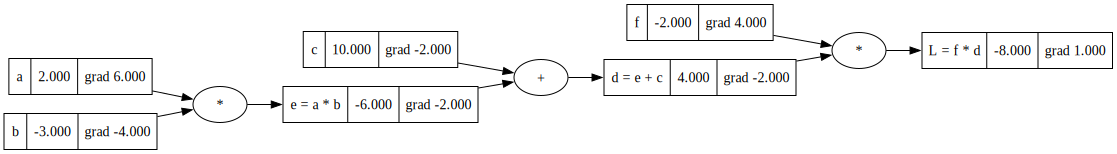

In [21]:

def dL_da(a, b, c, f):
    L, e, d = fnL(a, b, c, f)

    # dL / dL = 1
    L.grad = 1
    f.grad = d.v
    d.grad = f.v
    print("lL.grad:", f.grad, "d.v:", d.v)
    print("f.grad:", f.grad, "d.v:", d.v)
    c.grad = d.grad  # since d = c + e
    e.grad = d.grad
    ### already computed above
    # dL/da = dL/de * de/da
    # de/da = d/da (a) * d/da (b)
    #       =  b
    # ∴ dL/da = dL/de * b
    #         
    a.grad = e.grad * b.v
    b.grad = e.grad * a.v
    
    h = 0.0001
    a_h = Value(a.v + h, "a+h")
    L_h, _, _ = fnL(a_h, b, c, f)
    print("dL/da: (L+h - L) / h : ", (L_h.v  - L.v)/h)
    
    b_h = Value(b.v + h, "b+h")
    L_h, _, _ = fnL(a, b_h, c, f)
    print("dL/db: (L+h - L) / h : ", (L_h.v  - L.v)/h)
    print("f.grad:", f.grad, "d.v:", d.v)
    return L


def grok_dL_da():
    a = Value(2.0, "a") 
    b = Value(-3.0, "b") 
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    return dL_da(a, b, c, f)

L = grok_dL_da()
draw_dot(L)


# What does all this mean


Since we have the gradiant calculated if we nudge the values of the leaf notes in the direction of gradient, you can expect the L to go higher.
For example

```
a.v += 0.001 * a.grad
b.v += 0.001 * b.grad
c.v += 0.001 * c.grad
f.v += 0.001 * f.grad
```


lL.grad: 4.0 d.v: 4.0
f.grad: 4.0 d.v: 4.0
dL/da: (L+h - L) / h :  6.000000000021544
dL/db: (L+h - L) / h :  -4.000000000008441
f.grad: 4.0 d.v: 4.0
L =  Value(L: expr=f * d | v=-8.0 )
L =  Value(L: expr=f * d | v=-4.572000000000002 )


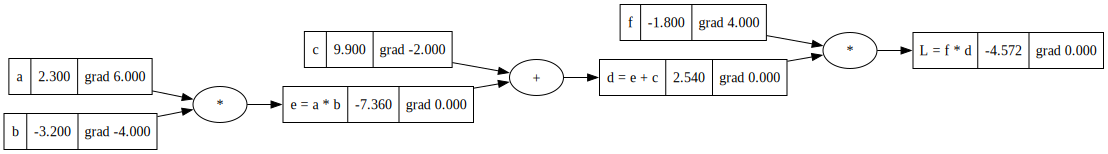

In [22]:
def grok_learning_rate(lr):
    a = Value(2.0, "a") 
    b = Value(-3.0, "b") 
    c = Value(10.0, "c") 
    f = Value(-2.0, "f")
    
    L = dL_da(a, b, c, f)
    print("L = ", L)

    a.v += a.grad * lr
    b.v += b.grad * lr
    c.v += c.grad * lr
    f.v += f.grad * lr
    L, _, _ = fnL(a, b, c, f)
    
    print("L = ", L)
    
    return draw_dot(L)


grok_learning_rate(0.05)

# Neural network 

Neuron is represented by 

1. $ activation(\Sigma({W_i} {X_i}) + B )$
2. activation can just $tanh$

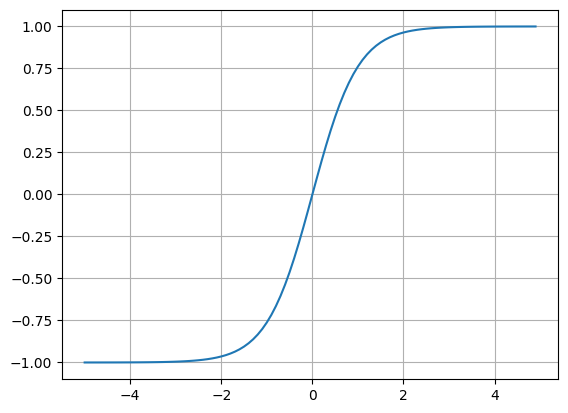

In [23]:
def grok_tanh():
    xs = np.arange(-5.0, 5.0, 0.1)
    plt.plot(xs, np.tanh(xs))
    plt.grid()

grok_tanh()

In [24]:
class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = f" {op} ".join(x.short_expr for x in parents)

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
    def __add__(self, other):
        return Value( v=self.v + other.v,  parents=(self, other),  op="+")

    def __sub__(self, other):
        return Value(v=self.v - other.v, parents=(self, other), op="-")
        
    def __mul__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="*")
        
    def __div__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="/")

    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        
        return Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        



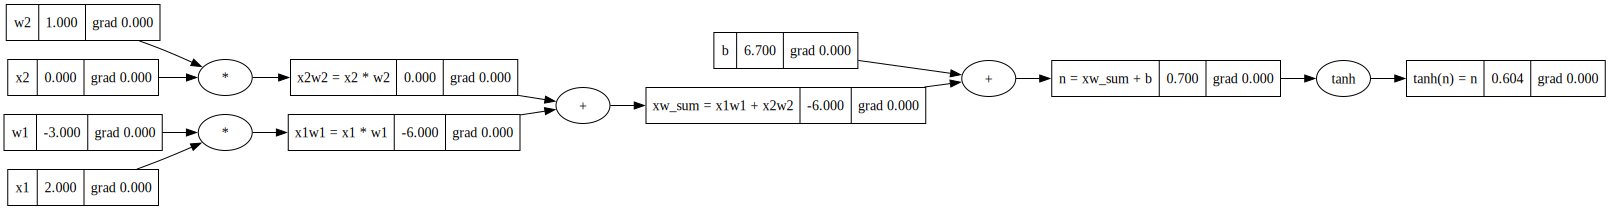

In [25]:
def grok_activation():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")

    # bias
    b = Value(6.7, "b")

    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'

    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    # At this point, we have to implement tanh
    o = n.tanh()
    
    return draw_dot(o)
    


grok_activation()

# 

# Backpropagation


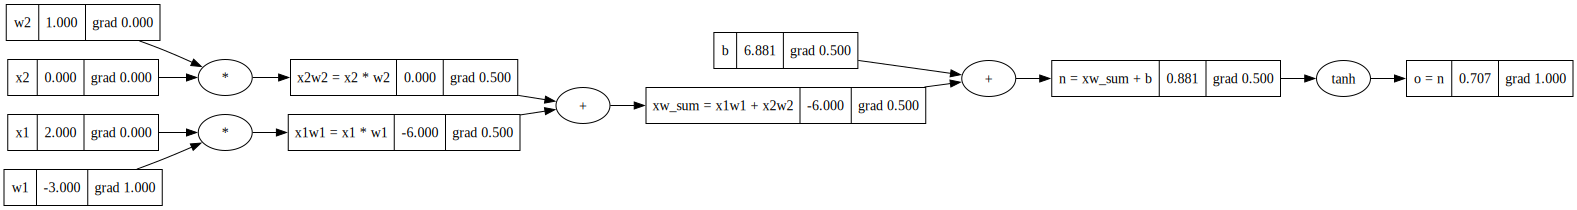

In [26]:
def grok_back_propagation():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")

    # bias
    b = Value(6.8813735870195432, "b")

    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'

    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    o = n.tanh() ; o.label = 'o'

    ### back propagation starts here ... 
    # 1. start by finding the grad
    # do/ do = 1
    o.grad = 1
    # do / dn  o = tanh(n)
    # d/dx tanh(x) = 1 - tanh^2(x)
    # -> dn/do = 1 - o^2
    
    n.grad = 1 - o.v**2
    # n = b + Σ xw
    b.grad = n.grad
    xw_sum.grad = n.grad

    # xw_sum = x1w1 + x2w2, so just copy the grad
    x1w1.grad = xw_sum.grad
    x2w2.grad = xw_sum.grad

    # w1 & w2 grad now !!
    w1.grad = x1.v * x1w1.grad
    w2.grad = x2.v * x2w2.grad
    return draw_dot(o)
    


grok_back_propagation()

### Making sense of it

So far, we know how to compute the gradient and how to back propogate it. 
Now lets add a _backward function to the Values so that calling _backward() will
apply what we just did manually


In [27]:
class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = None
        if len(parents) == 1:
            self.expr = f"{op}({parents[0].label})"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
    def __add__(self, other):
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad = ret.grad
            other.grad = ret.grad
        ret._backward = _backward
        return ret
            

    def __sub__(self, other):
        return Value(v=self.v - other.v, parents=(self, other), op="-")
        
    def __mul__(self, other):
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad = ret.grad * other.v
            other.grade = ret.grad * self.v
        ret._backward = _backward
        return ret
        
        
    def __div__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="/")

    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad = 1 - tanh**2
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret
        


Manual Back propagation


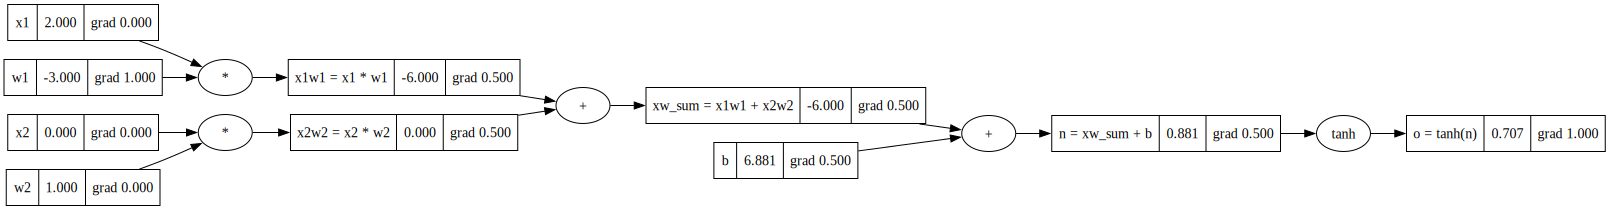

Using _backward


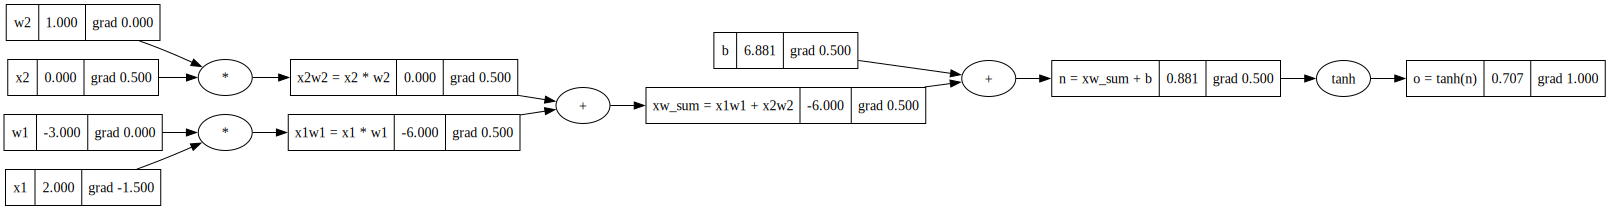

In [28]:
def implement_backward():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")

    # bias
    b = Value(6.8813735870195432, "b")

    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'

    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    o = n.tanh() ; o.label = 'o'

    ### back propagation starts here ... 
    # 1. start by finding the grad
    # do/ do = 1
    o.grad = 1
    
    # do / dn  o = tanh(n)
    # d/dx tanh(x) = 1 - tanh^2(x)
    # -> dn/do = 1 - o^2
    # n.grad = 1 - o.v**2
    o._backward()
    
    # n.grad = 1 - o.v**2
    # n = b + Σ xw
    # b.grad = n.grad
    # xw_sum.grad = n.grad
    n._backward()

    # xw_sum = x1w1 + x2w2, so just copy the grad
    # x1w1.grad = xw_sum.grad
    # x2w2.grad = xw_sum.grad

    xw_sum._backward()
    b._backward()
    # w1 & w2 grad now !!
    # w1.grad = x1.v * x1w1.grad
    # w2.grad = x2.v * x2w2.grad
    x2w2._backward()
    x1w1._backward()
    
    return draw_dot(o)
    

print("Manual Back propagation")
display(grok_back_propagation())

print("Using _backward")
implement_backward()

# Automate Backward using topological sort

We want to traverse the graph backwards and call each node's backward.


In [29]:
def sort_topologically(v):
  visited = set()
  topo = []

  def topo_sort(x):
      if x not in visited:
          visited.add(x)
          for p in x.parents:
              topo_sort(p)
          topo.append(x)
          
  topo_sort(v)
    
  return topo

def grok_topological_sort():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")

    # bias
    b = Value(6.8813735870195432, "b")

    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'

    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    o = n.tanh() ; o.label = 'o'

    return sort_topologically(o)


grok_topological_sort()


[Value(w1: expr=None | v=-3.0 ),
 Value(x1: expr=None | v=2.0 ),
 Value(x1w1: expr=x1 * w1 | v=-6.0 ),
 Value(x2: expr=None | v=0.0 ),
 Value(w2: expr=None | v=1.0 ),
 Value(x2w2: expr=x2 * w2 | v=0.0 ),
 Value(xw_sum: expr=x1w1 + x2w2 | v=-6.0 ),
 Value(b: expr=None | v=6.881373587019543 ),
 Value(n: expr=xw_sum + b | v=0.8813735870195432 ),
 Value(o: expr=tanh(n) | v=0.7071067811865476 )]

# Adding `backward` to Value


In [30]:
class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = None
        if len(parents) == 1:
            self.expr = f"{op}({parents[0].label})"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
    def __add__(self, other):
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad = ret.grad
            other.grad = ret.grad
        ret._backward = _backward
        return ret
            

    def __sub__(self, other):
        return Value(v=self.v - other.v, parents=(self, other), op="-")
        
    def __mul__(self, other):
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad = ret.grad * other.v
            other.grade = ret.grad * self.v
        ret._backward = _backward
        return ret
        
        
    def __div__(self, other):
        return Value(v=self.v * other.v, parents=(self, other), op="/")

    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad = 1 - tanh**2
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret

    def backward(self):
      visited = set()
      nodes = []
    
      def topo_sort(x):
          if x not in visited:
              visited.add(x)
              for p in x.parents:
                  topo_sort(p)
              nodes.append(x)
              
      topo_sort(self)
      self.grad = 1.0

      for x in reversed(nodes):
          print("calling backward of ", x.label)
          x._backward()
        
    
        

calling backward of  o
calling backward of  n
calling backward of  b
calling backward of  xw_sum
calling backward of  x2w2
calling backward of  w2
calling backward of  x2
calling backward of  x1w1
calling backward of  x1
calling backward of  w1


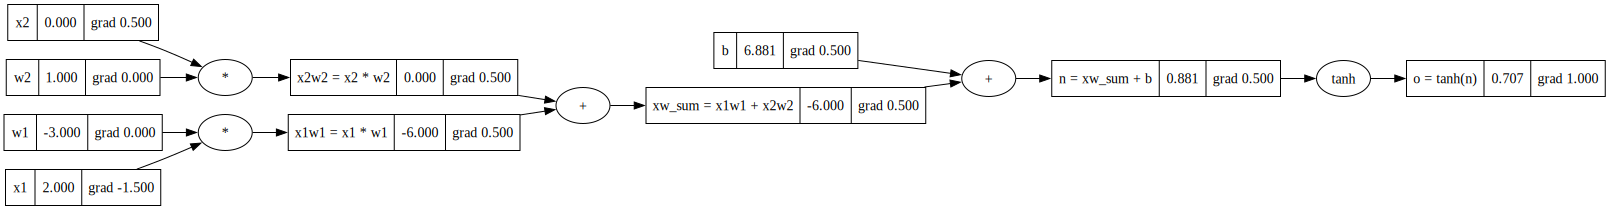

In [31]:
def try_value_backward():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")
    
    # bias
    b = Value(6.8813735870195432, "b")
    
    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'
    
    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    o = n.tanh() ; o.label = 'o'
    
    o.backward()
    
    return draw_dot(o)

try_value_backward()

# Huston we have a problem

what happens when we do $ b = a + a$ ? 

$ \frac{db}{da} =  \frac{d}{da}(a + a) $
$ = \frac{d}{da} a + \frac{d}{da} a$
$ = 1 + 1 $
$ = 2$

But in our example above grad of a overwrites the other grad. 

#### Solution 

Gradiant computation to add up!! 


In [32]:
# fixes grad accumulation 

class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = None
        if len(parents) == 1:
            self.expr = f"{op}({parents[0].label})"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
    def __add__(self, other):
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad += ret.grad
            other.grad += ret.grad
        ret._backward = _backward
        return ret
            

        
    def __mul__(self, other):
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad += ret.grad * other.v
            other.grade += ret.grad * self.v
        ret._backward = _backward
        return ret
        

    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh**2
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret

    def backward(self):
      visited = set()
      nodes = []
    
      def topo_sort(x):
          if x not in visited:
              visited.add(x)
              for p in x.parents:
                  topo_sort(p)
              nodes.append(x)
              
      topo_sort(self)
      self.grad = 1.0

      for x in reversed(nodes):
          print("calling backward of ", x.label)
          x._backward()
        
    
        

calling backward of  b
calling backward of  a


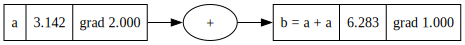

In [33]:
def validate_gradiant_fix():
    a = Value(3.1415, 'a')
    b = a + a; b.label = 'b'
    b.backward()
    return draw_dot(b)

validate_gradiant_fix()




# Support `a + 1` and `1 + a`

In [34]:
# Support a + 1.0 and 1 + a, same for multiply


class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = expr
        if len(parents) == 1:
            self.expr = f"{op}({parents[0].label})"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad += ret.grad
            other.grad += ret.grad
        ret._backward = _backward
        return ret
        
    def __radd__(self, other):
        return self + Value(other)
            

        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad += ret.grad * other.v
            other.grad += ret.grad * self.v
        ret._backward = _backward
        return ret
        
    def __rmul__(self, other):
        return self * Value(other)

    def exp(self):
        """
        compute e^x where x is self
        """
        x = self.v
        ex = np.exp(x)
        
        ret = Value(ex, f"e^{x}", parents=(self,), op="exp")
        def _backward():
            self.grad += ex * ret.grad # 💡 adding * out.grad to do dL/da = dL/dd * dd/da
        ret._backward = _backward
        return ret

    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh**2 * ret.grad
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret

    def backward(self):
      visited = set()
      nodes = []
    
      def topo_sort(x):
          if x not in visited:
              visited.add(x)
              for p in x.parents:
                  topo_sort(p)
              nodes.append(x)
              
      topo_sort(self)
      self.grad = 1.0

      for x in reversed(nodes):
          print("calling backward of ", x.label)
          x._backward()
        
    
        

In [35]:
def test_add_mul_exp_and_reverse():
    a = Value(3.1415, 'a')
    b = a + 1 ;
    print(b)
    c = 1 + a
    print(c)

    d = 2 * a  + 5
    print(d)
    x = Value(1, "x")
    print(x.exp())
    
    

test_add_mul_exp_and_reverse()

Value(: expr=a +  | v=4.141500000000001 )
Value(: expr=a +  | v=4.141500000000001 )
Value(: expr=a *  +  | v=11.283000000000001 )
Value(e^1: expr=exp(x) | v=2.718281828459045 )


calling backward of  o
calling backward of  cw_exp
calling backward of  cw
calling backward of  w_c
calling backward of  c
calling backward of  aw_bw
calling backward of  bw
calling backward of  b
calling backward of  w_b
calling backward of  aw
calling backward of  a
calling backward of  w_a


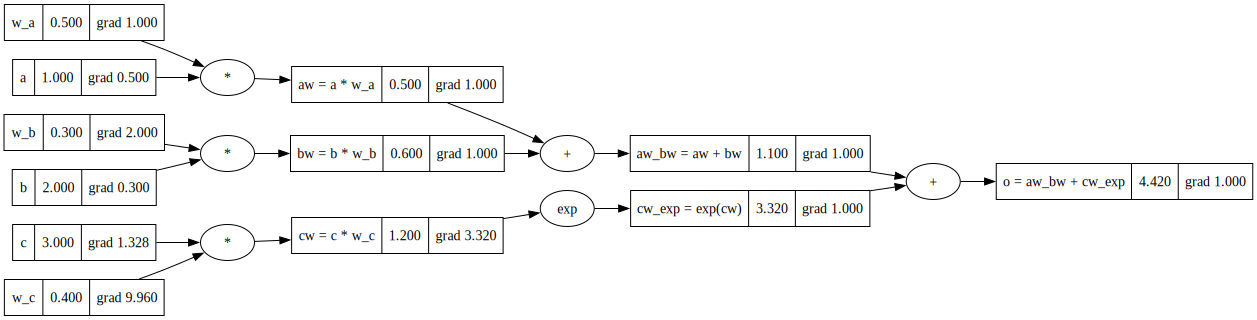

In [36]:
# let test a chain rule that involves e^x

def test_chain_exp():
  a = Value(1, 'a')
  w_a = Value(0.5, 'w_a')

  aw  = a * w_a; aw.label = 'aw'
    
  b = Value(2, 'b')
  w_b = Value(0.3, 'w_b')
  bw = b * w_b; bw.label = 'bw'

  c = Value(3.0, 'c')
  w_c = Value(0.4, 'w_c')
  cw = c * w_c; cw.label = 'cw'

    
  aw_plus_bw = aw + bw; aw_plus_bw.label = 'aw_bw'
    
  cw_exp = cw.exp(); cw_exp.label='cw_exp'

  o = aw_plus_bw + cw_exp; o.label = 'o'

  o.backward()
  return draw_dot(o)

test_chain_exp()

    

## Learning  


### Why do we use * in grad computation?

```python
    self.grad += ret.grad * other.v
```
#### Explanation 

Chain rule:  $ \frac{d}{da} L = \frac {dL}{do} \times \frac{do}{dd} \times \frac{dd}{da}$

In the chain rule we multiply each derivative with the next. 



# Implement Division

To implement division we can implement 
$ a/b = a * b**-1$

In [37]:
# Support a/b in terms of a * b**-1

class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = expr
        if len(parents) == 1:
            p = parents[0]
            self.expr = f"{op}({p.label})" if op.isalpha() else f"{p.label} {op}"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        return f"Value({self.label}: expr={self.expr} | v={self.v} )"
        
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad += 1.0 * ret.grad
            other.grad += 1.0 * ret.grad
        ret._backward = _backward
        return ret
        
    def __radd__(self, other):
        return self + Value(other)

    def __sub__(self, other):
        neg_other = -other
        diff = self + neg_other; diff.op='-'
        return diff

    def __neg__(self):
        neg = self * -1
        neg.label = f'-{neg.expr}'
        return neg

        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad += ret.grad * other.v
            other.grad += ret.grad * self.v
        ret._backward = _backward
        return ret

    def __rmul__(self, other):
        return self * Value(other)

    def exp(self):
        """
        compute e^x where x is self
        """
        x = self.v
        ex = np.exp(x)
        
        ret = Value(ex, f"e^{x}", parents=(self,), op="exp")
        def _backward():
            self.grad += ex * ret.grad # 💡 adding * out.grad to do dL/da = dL/dd * dd/da
        ret._backward = _backward
        return ret

    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh**2 * ret.grad
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret

    def backward(self):
      visited = set()
      nodes = []
    
      def topo_sort(x):
          if x not in visited:
              visited.add(x)
              for p in x.parents:
                  topo_sort(p)
              nodes.append(x)
              
      topo_sort(self)
      self.grad = 1.0

      for x in reversed(nodes):
          print("calling backward of ", x.label)
          x._backward()
        
        
    def __pow__(self, index):
        result = self.v ** index
        ret = Value(result, parents=(self,), op=f'**{index}')
        
        def _backward():
            # d/dx x^n = n x^n -1
            self.grad += index * self.v ** (index-1) * ret.grad
        ret._backward = _backward
        return ret
        
        
    def __truediv__(self, other):
        ret = self * other**-1
        ret.op = '➗'
        return ret

Value(x: expr= | v=21.0 ) Value(x^2: expr=x **2 | v=441.0 )
Value(y: expr= | v=9 )
Value(z: expr=x^2 * y **-1 | v=49.0 )


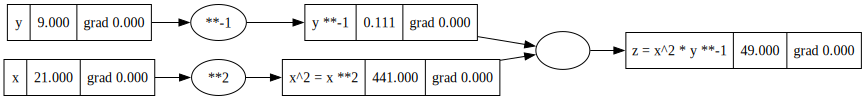

Backward
calling backward of  z
calling backward of  
calling backward of  y
calling backward of  x^2
calling backward of  x


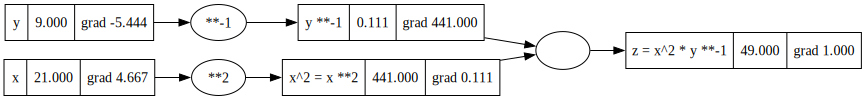

In [38]:
def validate_exp_div():
    x = Value(7.0*3, 'x')
    x_2 = x**2; x_2.label = 'x^2'
    print(x, x_2)

    y = Value(9, 'y')
    z = x_2 / y; z.label = 'z'
    print(y)
    print(z)
    display(draw_dot(z))

    print("Backward")
    z.backward()
    # x^2 =  21^2 = 441 
    # d/dx = 2x = 2*21 = 42
    # d/dx * dx/dL = 42 x 0.111 = 4.667
    return draw_dot(z)
    

validate_exp_div()

Value(x: expr= | v=21.0 ) Value(x^2: expr=x **2 | v=441.0 )
Value(y: expr= | v=9 )
Value(z: expr=x^2 * y **-1 | v=49.0 )


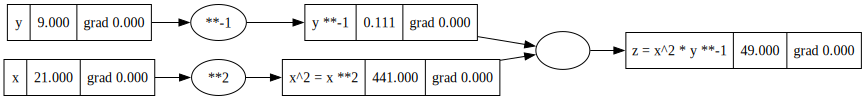

Backward
calling backward of  z
calling backward of  
calling backward of  y
calling backward of  x^2
calling backward of  x


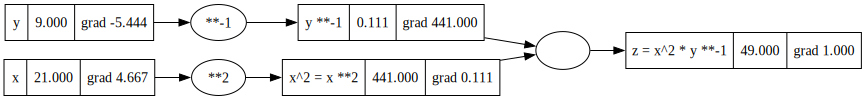

In [39]:
def validate_sub_neg():
    x = Value(3, 'x')
    x_2 = x**2; x_2.label = 'x^2'
    neg_x_2 = -x_2
    
    print(x, x_2)

    y = Value(9, 'y')
    z = x_2 / y; z.label = 'z'
    print(y)
    print(z)
    display(draw_dot(z))

    print("Backward")
    z.backward()
    # x^2 =  21^2 = 441 
    # d/dx = 2x = 2*21 = 42
    # d/dx * dx/dL = 42 x 0.111 = 4.667
    return draw_dot(z)
    

validate_exp_div()

# Redefine tanh in terms of $ e^x $

$ \tanh(x) = \frac{e^{2x} + 1}{e^{2x} - 1} $


expect:  Value(tanh(pi): expr=tanh(pi) | v=0.9962602049458319 )
actual:  tanh( 3.14 ) Value(tahn: expr=e^2x + -1 *  **-1 | v=0.9962602049458319 )
calling backward of  tanh(pi)
calling backward of  pi


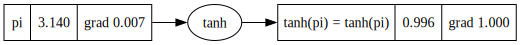

calling backward of  tahn
calling backward of  
calling backward of  
calling backward of  1
calling backward of  
calling backward of  e^2x
calling backward of  2 pi
calling backward of  pi
calling backward of  2
calling backward of  -1


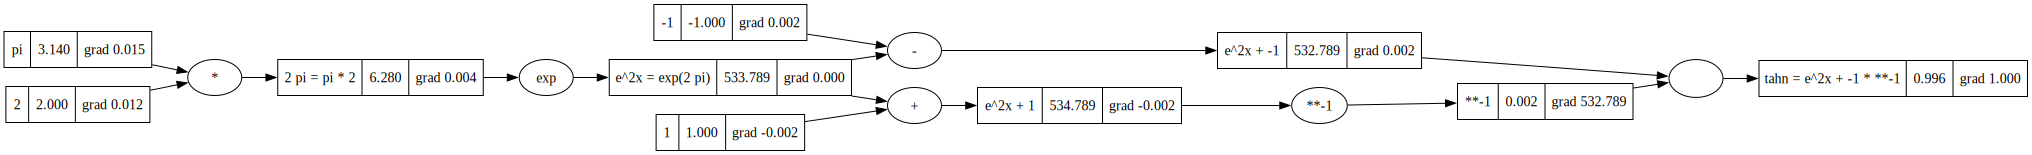

In [40]:
def implement_tahn_ex():
    x = Value(3.14, 'pi')
    x2 = x * 2; x2.label = '2 pi'
    
    e_2x = x2.exp(); e_2x.label = 'e^2x'
    tanh = (e_2x - 1) /  (e_2x + 1); tanh.label = 'tahn'
    
    expected = x.tanh()
    print("expect: ", expected)
    print("actual: ", f"tanh( {x.v} )", tanh)
    
    expected.backward()
    display(draw_dot(expected))
    
    tanh.backward()
    return draw_dot(tanh)


implement_tahn_ex()

## Lets use that in Value


In [41]:
# Support tanh in terms of e^2x - 1 / e^2x + 1

class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = expr
        if len(parents) == 1:
            p = parents[0]
            self.expr = f"{op}({p.label})" if op.isalpha() else f"{p.label} {op}"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        if not self.expr:
          return f"Value({self.label}: {self.v} | g={self.grad} )"
        
        return f"Value({self.label}: {self.expr} | v={self.v} | g={self.grad} )"

        
        
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad += 1.0 * ret.grad
            other.grad += 1.0 * ret.grad
        ret._backward = _backward
        return ret
        
    def __radd__(self, other):
        return self + Value(other)

    def __sub__(self, other):
        neg_other = -other
        diff = self + neg_other; diff.op='-'
        return diff

    def __neg__(self):
        neg = self * -1
        neg.label = f'-{neg.expr}'
        return neg

        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad += ret.grad * other.v
            other.grad += ret.grad * self.v
        ret._backward = _backward
        return ret

    def __rmul__(self, other):
        return self * Value(other)

    def exp(self):
        """
        compute e^x where x is self
        """
        x = self.v
        ex = np.exp(x)
        
        ret = Value(ex, f"e^{x}", parents=(self,), op="exp")
        def _backward():
            self.grad += ex * ret.grad # 💡 adding * out.grad to do dL/da = dL/dd * dd/da
        ret._backward = _backward
        return ret
        

    def tanh_old(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh**2 * ret.grad
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret
        
    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        _2x = self * 2; _2x.label = '2x'
        e_2x = _2x.exp(); e_2x.label = 'e^2x'
        numerator = e_2x - 1; numerator.label = 'numerator'
        denominator = e_2x + 1; denominator.label = 'denominator'
        
        tanh = numerator / denominator; tanh.label = 'tanh'
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh.v**2 * tanh.grad
            
        tanh._backward = _backward
        return tanh

    def backward(self):
      visited = set()
      nodes = []
    
      def topo_sort(x):
          if x not in visited:
              visited.add(x)
              for p in x.parents:
                  topo_sort(p)
              nodes.append(x)
              
      topo_sort(self)
      self.grad = 1.0

      for x in reversed(nodes):
          #print("calling backward of ", x.label)
          x._backward()
        
        
    def __pow__(self, index):
        result = self.v ** index
        ret = Value(result, parents=(self,), op=f'**{index}')
        
        def _backward():
            # d/dx x^n = n x^n -1
            self.grad += index * self.v ** (index-1) * ret.grad
        ret._backward = _backward
        return ret
        
        
    def __truediv__(self, other):
        ret = self * other**-1
        ret.label = '/'
        return ret

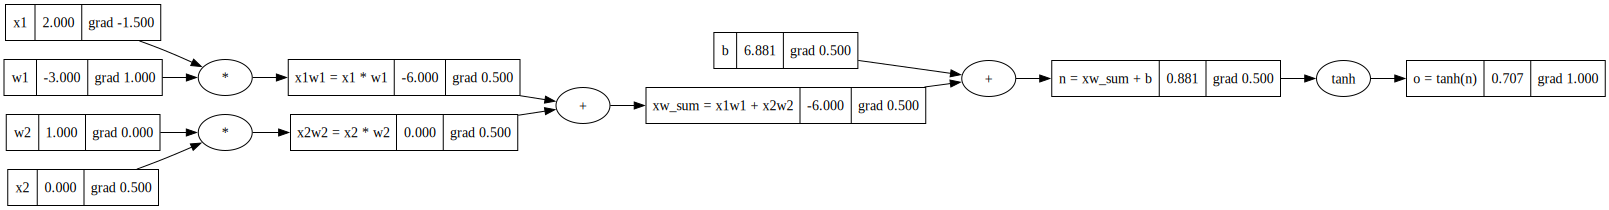

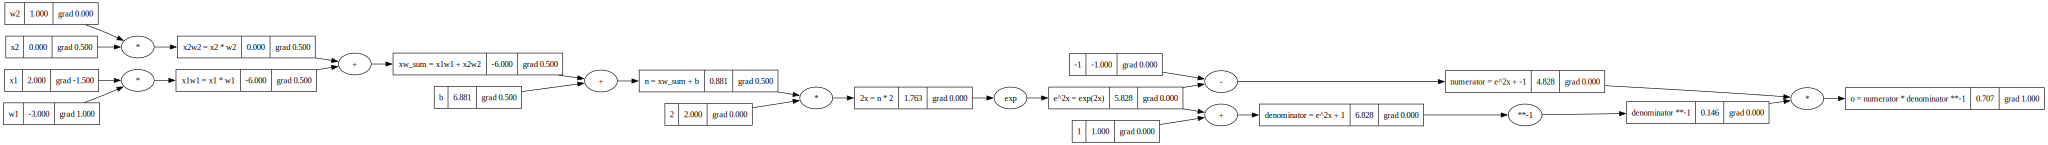

In [42]:
def old_tanh():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")
    
    # bias
    b = Value(6.8813735870195432, "b")
    
    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'
    
    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    o = n.tanh_old() ; o.label = 'o'
    
    o.backward()
    return draw_dot(o)
    
def try_new_tanh():
    x1 = Value(2.0, "x1")
    x2 = Value(0.0, "x2")
    # weights
    w1 = Value(-3.0, "w1")
    w2 = Value(1.0, "w2")
    
    # bias
    b = Value(6.8813735870195432, "b")
    
    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'
    
    xw_sum = x1w1 + x2w2; xw_sum.label = 'xw_sum'
    
    n =  xw_sum + b; n.label = 'n'
    o = n.tanh() ; o.label = 'o'
    o.backward()

    return draw_dot(o)
    

display(old_tanh())
try_new_tanh()

# Neural Net

In [43]:
import random

class Neuron:
    def __init__(self, n):
        self.w = [Value(random.uniform(-1, 1), f"w{x+1}") for x in range(n)]
        self.b = Value(random.uniform(-1, 1), 'b')
        
    def __call__(self, xs):
        # Σ (Wi Xi) + b
        acc = sum( ((wi * xi)  for wi, xi in zip(self.w, xs)), self.b)
        o = acc.tanh()
        return o
        
    def backward(self):
        pass
        

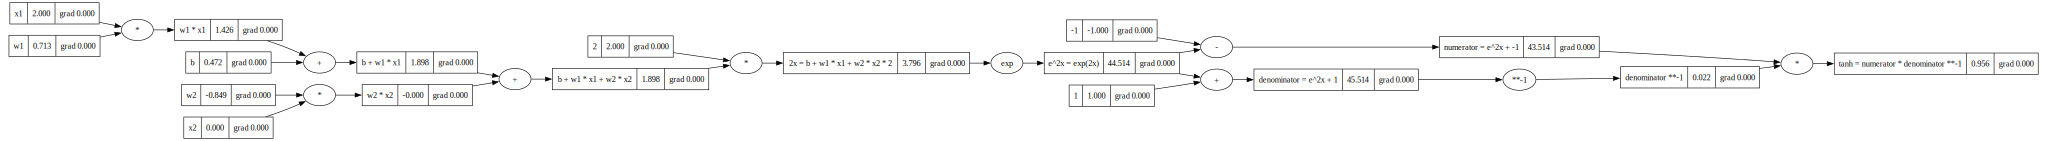

In [44]:
def try_neuron():
    x1 = Value(2.0, 'x1')
    x2 = Value(0.0, 'x2')
    n = Neuron(2)
    o = n([x1, x2])
    
    return draw_dot(o)

try_neuron()

In [45]:
class Layer:
    def __init__(self, inp, out):
        #  2    4  will create 4 neurons each taking 2 inputs
        # > n1 -
        # > n2 -
        # > n3 -
        # > n4 -
        
        self.ns = [Neuron(inp) for _ in range(out) ]

    def __call__(self, xs):
        out = [ n(xs) for n in self.ns]
        return out
        
                   

                    

In [46]:
def try_layer():
    x1 = Value(2.0, 'x1')
    x2 = Value(0.0, 'x2')
    layer = Layer(2, 3)
    out = layer([x1, x2])
    display(out)

try_layer()


[Value(tanh: numerator * denominator **-1 | v=-0.00964359135535162 | g=0.0 ),
 Value(tanh: numerator * denominator **-1 | v=0.8594881056616048 | g=0.0 ),
 Value(tanh: numerator * denominator **-1 | v=-0.27406898707178873 | g=0.0 )]

In [47]:
class MLP:
    def __init__(self, inp, layers):
        # 3,     [4, 2   1]
        # input  Hidden
        #        O
        #   o    O   O  
        #   o           O
        #   o    O   O
        #        O
        all_layers = [inp] + layers
        #  prev -> next : Layer(prev, next)
        self.layers = [ Layer(all_layers[i], all_layers[i+1]) for i in range(len(all_layers)-1) ]


    def __call__(self, xs):
        x = xs
        for l in self.layers:
            x = l(x)

        return x if len(x) > 1 else x[0]
        

In [48]:
def try_mlp():
    xs = [2.0, 3.0, 0.0]
    nn = MLP(3, [4, 4, 1])
    out = nn(xs)
    return out 

try_mlp()

Value(tanh: numerator * denominator **-1 | v=0.6707389034080913 | g=0.0 )

# How to train a network

In [49]:
def train_nn():
    xs = [
        [2.0, 3.0, -1.0],  #  1.0
        [3.0, -1.0, 0.5],  # -1.0
        [0.5, 1.0, 1.0],   # -1.0
        [1.0, 1.0, -1.0],  #  1.0
    ]
    ys = [1.0, -1.0, -1.0, 1.0]

    nn = MLP(3, [4, 4, 1])
    y_pred = [ nn(x) for x in xs ]
    print("y_pred for all inputs")
    display(y_pred)

    # now lets compute the loss .. 
    losses = [  (y_pred - y_train)**2  for y_pred, y_train in zip(y_pred, ys)]
    print("Losses ..... ")
    display(losses)

    print("Loss as a single number")
    loss = sum(losses)
    display(loss)

train_nn()

y_pred for all inputs


[Value(tanh: numerator * denominator **-1 | v=-0.05363391788285851 | g=0.0 ),
 Value(tanh: numerator * denominator **-1 | v=-0.9810439172783245 | g=0.0 ),
 Value(tanh: numerator * denominator **-1 | v=-0.5421344473017378 | g=0.0 ),
 Value(tanh: numerator * denominator **-1 | v=-0.41229567446893745 | g=0.0 )]

Losses ..... 


[Value(:  **2 | v=1.110144432913182 | g=0.0 ),
 Value(:  **2 | v=0.00035933307215100374 | g=0.0 ),
 Value(:  **2 | v=0.20964086434768514 | g=0.0 ),
 Value(:  **2 | v=1.994579072123671 | g=0.0 )]

Loss as a single number


Value(:  **2 +  +  **2 +  **2 +  **2 | v=3.314723702456689 | g=0.0 )

## Reducing loss

we have an MLP with `Layers` and each `Layer` has `Neuron` which has `Weights` and `Bias` as `Values`
We need a way to extract all the values and then changes its data by `-grad` * `learning_rate` 


In [50]:
# Introducing parameters of a NN 


class Neuron:
    def __init__(self, n):
        self.w = [Value(random.uniform(-1, 1), f"w{x+1}") for x in range(n)]
        self.b = Value(random.uniform(-1, 1), 'b')
        
    def __call__(self, xs):
        # Σ (Wi Xi) + b
        acc = sum( ((wi * xi)  for wi, xi in zip(self.w, xs)), self.b)
        o = acc.tanh()
        return o
        
    def parameters(self):
        # print("   ... ... neuron/params", len(self.w + [self.b]))
        return self.w + [self.b]
        

class Layer:
    def __init__(self, inp, out):
        #  2    4  will create 4 neurons each taking 2 inputs
        # > n1 -
        # > n2 -
        # > n3 -
        # > n4 -
        
        self.ns = [Neuron(inp) for _ in range(out) ]

    def __call__(self, xs):
        out = [ n(xs) for n in self.ns]
        return out
        
    def parameters(self):
        # print(" ... layers/neurons: ", len(self.ns))
        return [p for neuron in self.ns for p in neuron.parameters() ]

        
class MLP:
    def __init__(self, inp, hidden):
        # 3,     [4, 2   1]
        # input  Hidden
        #        O
        #   o    O   O  
        #   o           O
        #   o    O   O
        #        O
        all_layers = [inp] + hidden
        
        #  prev -> next : Layer(prev, next)
        self.layers = [ Layer(all_layers[i], all_layers[i+1]) for i in range(len(all_layers)-1) ]


    def __call__(self, xs):
        x = xs
        for l in self.layers:
            x = l(x)

        return x if len(x) > 1 else x[0]

    def parameters(self):
        print("Layers: ", len(self.layers))
        return [p for layer in self.layers for p in layer.parameters() ]
        


In [51]:

def implement_parameters():
    xs = [
        [2.0, 3.0, -1.0],  #  1.0
        [3.0, -1.0, 0.5],  # -1.0
        [0.5, 1.0, 1.0],   # -1.0
        [1.0, 1.0, -1.0],  #  1.0
    ]
    ys = [1.0, -1.0, -1.0, 1.0]

    nn = MLP(3, [4, 4, 1])
    y_pred = [ nn(x) for x in xs ]
    # now lets compute the loss .. 
    losses = [  (y_pred - y_train)**2  for y_pred, y_train in zip(y_pred, ys)]

    loss = sum(losses)
    print("Loss: ",loss)
    
    loss.backward()
    params = nn.parameters()
    print("number of weights and bias (parameters): ", len(params))
    

implement_parameters()

Loss:  Value(:  **2 +  +  **2 +  **2 +  **2 | v=3.189981949690928 | g=0.0 )
Layers:  3
number of weights and bias (parameters):  41


In [98]:

# Support tanh in terms of e^2x - 1 / e^2x + 1

class Value:
    def __init__(self, v: float, label="", parents=(), op="", expr=""):
        self.v = v
        self.parents= set(parents) 
        self.op = op
        self.grad = 0.0
        self.label = label
        self.expr = expr
        if len(parents) == 1:
            p = parents[0]
            self.expr = f"{op}({p.label})" if op.isalpha() else f"{p.label} {op}"
        elif len(parents) > 1:
            self.expr = f" {op} ".join(x.short_expr for x in parents)
        
        # add backward as a function that can change with each operation
        self._backward = lambda: None

    @property
    def short_expr(self):
        return self.label if self.label else self.expr
        
    @property
    def full_expr(self):
        if self.expr:
            if self.label:
                return f"{self.label} = {self.expr}"
            return self.expr
        
        return self.label
                
    def __repr__(self):
        if not self.expr:
          return f"Value({self.label}: {self.v} | g={self.grad} )"
        
        return f"Value({self.label}: {self.expr} | v={self.v} | g={self.grad} )"

        
        
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value( v=self.v + other.v,  parents=(self, other),  op="+")
        
        def _backward():
            self.grad += 1.0 * ret.grad
            other.grad += 1.0 * ret.grad
        ret._backward = _backward
        return ret
        
    def __radd__(self, other):
        return self + Value(other)

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value( v=self.v - other.v,  parents=(self, other),  op="-")
        
        def _backward():
            self.grad += -1.0 * ret.grad
            other.grad += -1.0 * ret.grad
        ret._backward = _backward
        return ret
        
    def __rsub__(self, other):
        return Value(other) - self
        

    def __neg__(self):
        neg = self * -1
        neg.label = f'-{neg.expr}'
        return neg

        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other, label=f"{other}")
        ret = Value(v=self.v * other.v, parents=(self, other), op="*")
        def _backward():
            self.grad += ret.grad * other.v
            other.grad += ret.grad * self.v
        ret._backward = _backward
        return ret

    def __rmul__(self, other):
        return self * Value(other)

    def exp(self):
        """
        compute e^x where x is self
        """
        x = self.v
        ex = np.exp(x)
        
        ret = Value(ex, f"e^{x}", parents=(self,), op="exp")
        def _backward():
            self.grad += ex * ret.grad # 💡 adding * out.grad to do dL/da = dL/dd * dd/da
        ret._backward = _backward
        return ret
        

    def tanh_old(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        x = self.v
        tanh = (np.exp(2*x) - 1) / (np.exp(2*x) + 1)
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh**2 * ret.grad
            
        ret =  Value(tanh, f"tanh({self.label})", parents=(self,), op="tanh")
        ret._backward = _backward
        return ret
        
    def tanh(self):
        # v = np.tanh(self.v)
        # we could just do that but lets implement tanh in terms of e^x
        #   2x
        # e      - 1
        # --------------------- 
        #   2x
        # e      + 1
        # refer: https://brilliant.org/wiki/hyperbolic-trigonometric-functions/ 
        
        _2x = self * 2; _2x.label = '2x'
        e_2x = _2x.exp(); e_2x.label = 'e^2x'
        numerator = e_2x - 1; numerator.label = 'numerator'
        denominator = e_2x + 1; denominator.label = 'denominator'
        
        tanh = numerator / denominator; tanh.label = 'tanh'
        def _backward():
            # d/dx tanh(x) = 1 - tanh^2(x)
            # -> dn/do = 1 - o^2
            self.grad += 1 - tanh.v**2 * tanh.grad
            
        tanh._backward = _backward
        return tanh

    def backward(self):
      visited = set()
      nodes = []
    
      def topo_sort(x):
          if x not in visited:
              visited.add(x)
              for p in x.parents:
                  topo_sort(p)
              nodes.append(x)
              
      topo_sort(self)
      self.grad = 1.0

      for x in reversed(nodes):
          #print("calling backward of ", x.label)
          x._backward()
        
        
    def __pow__(self, index):
        result = self.v ** index
        ret = Value(result, parents=(self,), op=f'**{index}')
        
        def _backward():
            # d/dx x^n = n x^n -1
            self.grad += index * self.v ** (index-1) * ret.grad
        ret._backward = _backward
        return ret
        
        
    def __truediv__(self, other):
        ret = self * other**-1
        ret.label = '/'
        return ret
class Neuron:
    def __init__(self, n):
        self.w = [Value(random.uniform(-1, 1), f"w{x+1}") for x in range(n)]
        self.b = Value(random.uniform(-1, 1), 'b')
        
    def __call__(self, xs):
        # Σ (Wi Xi) + b
        acc = sum( ((wi * xi)  for wi, xi in zip(self.w, xs)), self.b)
        o = acc.tanh_old()
        return o
        
    def parameters(self):
        # print("   ... ... neuron/params", len(self.w + [self.b]))
        return self.w + [self.b]

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0
        

class Layer:
    def __init__(self, inp, out):
        #  2    4  will create 4 neurons each taking 2 inputs
        # > n1 -
        # > n2 -
        # > n3 -
        # > n4 -
        
        self.neurons = [Neuron(inp) for _ in range(out) ]

    def __call__(self, xs):
        out = [ n(xs) for n in self.neurons]
        return out
        
    def parameters(self):
        # print(" ... layers/neurons: ", len(self.ns))
        return [p for n in self.neurons for p in n.parameters() ]
        
    def zero_grad(self):
      for n in self.neurons:
          n.zero_grad()

        
class MLP:
    def __init__(self, inp, hidden):
        # 3,     [4, 2   1]
        # input  Hidden
        #        O
        #   o    O   O  
        #   o           O
        #   o    O   O
        #        O
        all_layers = [inp] + hidden
        
        #  prev -> next : Layer(prev, next)
        self.layers = [ Layer(all_layers[i], all_layers[i+1]) for i in range(len(all_layers)-1) ]


    def __call__(self, xs):
        x = xs
        for l in self.layers:
            x = l(x)

        return x if len(x) > 1 else x[0]

    def parameters(self):
        return [p for l in self.layers for p in l.parameters() ]
        
    def zero_grad(self):
        for l in self.layers:
            l.zero_grad()
        


In [237]:
train_xs = [
    [2.0],  #  1.0
    [-2.0],  # -1.0
    [-3.5],   # -1.0
    [3.0],  #  1.0
]
train_ys = [1.0, -1.0, -1.0, 1.0]
nn = MLP(1, [1])

In [381]:
def reduce_loss(nn):

    learning_rate = 0.001

    def train(it):
        print(f"----------------------------- {it} ------------------------------")
        # display(nn.parameters())
        y_pred = [ nn(xs) for xs in train_xs ]
        print(" ... ys    : ",train_ys)
        print(" ... pred  : ",[float(v.v) for v in y_pred])
        
        losses = [(y_train - y_pred)  for y_train, y_pred in zip(train_ys, y_pred)]
        print(" ... losses: ",[float(v.v) for v in losses])
        # print(" ... actual: ", [float(y_train - y_pred.v)  for y_train, y_pred in zip(train_ys, y_pred)])
        
        loss = sum(l**2 for l in losses)
        print(" ... loss  :      ",loss.v)
    
        nn.zero_grad()
        loss.backward()
        # display(nn.parameters())
        
        for p in nn.parameters():
            p.v += (p.grad * learning_rate)

    for i in range(5):
        train(i)

reduce_loss(nn)


----------------------------- 0 ------------------------------
 ... ys    :  [1.0, -1.0, -1.0, 1.0]
 ... pred  :  [0.9436496782529034, -0.3844559783369728, -0.8399916286375674, 0.9806513337218112]
 ... losses:  [0.05635032174709664, -0.6155440216630272, -0.16000837136243262, 0.019348666278188764]
 ... loss  :       0.4080468511588976
----------------------------- 1 ------------------------------
 ... ys    :  [1.0, -1.0, -1.0, 1.0]
 ... pred  :  [0.9442666132099546, -0.3829238287798241, -0.8398895022957279, 0.9809037529594645]
 ... losses:  [0.05573338679004536, -0.6170761712201759, -0.1601104977042721, 0.019096247040535475]
 ... loss  :       0.40988924961698353
----------------------------- 2 ------------------------------
 ... ys    :  [1.0, -1.0, -1.0, 1.0]
 ... pred  :  [0.944875852213524, -0.38138143709099026, -0.839782290984328, 0.981152328336145]
 ... losses:  [0.05512414778647601, -0.6186185629090097, -0.160217709015672, 0.018847671663855037]
 ... loss  :       0.4117525470541